In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader

from mingpt.utils import set_seed
from mingpt.model import GPT
from mingpt.trainer import Trainer

c:\Users\dalli\anaconda3\envs\pydl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set model hyperparameters
select_mingpt = True
model_architecture = 'gpt2'
device = 'cpu'
set_seed(42)

Dataset

In [3]:
# load data
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", "plain_text", cache_dir="datasets")["train"]

Found cached dataset red_pajama-data-1_t-sample (c:/Users/dalli/source/repos/CS674/lab2/minGPT/datasets/togethercomputer___red_pajama-data-1_t-sample/plain_text/1.0.0/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039)
100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


In [4]:
# dataset class
class RedPajama(Dataset):
    def __init__(self, data, max_length=1024):
        # super().__init__()
        self.data = data
        self.max_length = max_length
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_architecture)
        self.tokenizer.pad_token_id = 50256
        self.vocab_size = self.tokenizer.vocab_size

    def __len__(self):
        # return the number of data points
        return len(self.data)
    
    def __getitem__(self, idx):
        # load and tokenize the text
        text = self.data[idx]["text"]
        tokens = self.tokenizer.encode(text, 
                                       add_special_tokens=True, 
                                       max_length=self.max_length,
                                       truncation=True,
                                       return_tensors="pt",
                                       padding=True)
        
        # split and shift tokens after excluding the CLS token
        targets = tokens[:, 1:].clone()
        tokens = tokens[:, :-1].clone()

        return tokens, targets

rp_dataset = RedPajama(dataset)

In [5]:
# set up data path
path = "./checkpoints/redpajama"

if not os.path.exists(path):
    os.makedirs(path)
    checkpoints = os.listdir(path)
else:
    checkpoints = os.listdir(path)
checkpoints.sort()

Model

In [6]:
# set up model configurations
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = rp_dataset.vocab_size
model_config.block_size = rp_dataset.max_length
model_config.checkpoint = 'checkpoints/' + checkpoints[-1] if checkpoints else None

# set up model with configurations
model = GPT(model_config)

number of parameters: 2.55M


In [7]:
# set up trainer configurations
max_iters = 500
train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = max_iters + model.iter_num if model_config.checkpoint else max_iters
train_config.num_workers = 0
train_config.checkpoint_iters = 100 
train_config.batch_size = 1
train_config.checkpoint_name = path

# set up trainer with configurations
trainer = Trainer(train_config, model, rp_dataset)

running on device cpu


In [9]:
# train model
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 746.75ms; iter 0: train loss 7.65731
iter_dt 1411.00ms; iter 100: train loss 7.64239
iter_dt 1258.00ms; iter 200: train loss 8.28406
iter_dt 534.00ms; iter 300: train loss 7.24194
iter_dt 276.00ms; iter 400: train loss 7.55407


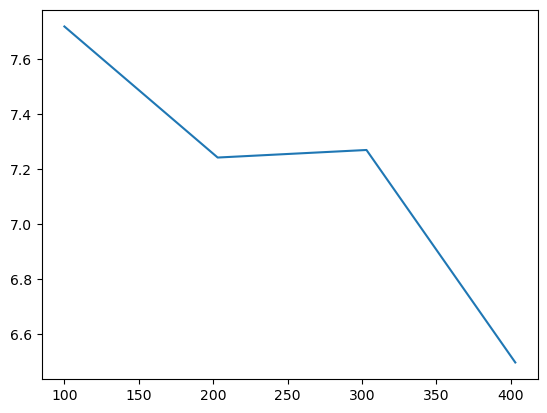

In [11]:
# show loss
plt.plot(trainer.iter_list, [a.detach() for a in trainer.saved_loss])
plt.show()

Use Model

In [12]:
def generate(prompt="", sample_count=10, steps=20, do_sample=True):
    # handle empty prompt
    if prompt == "": prompt = "<|endoftext|>"
    
    # tokenize and encode the prompt in batches
    tokenizer = GPT2Tokenizer.from_pretrained(model_architecture)
    tokenized = tokenizer(prompt, return_tensors="pt").to(device)
    input = tokenized["input_ids"].expand(sample_count, -1)

    # generate output
    output = model.generate(input, max_new_tokens=steps, do_sample=do_sample, top_k=40)
    for i in range(sample_count):
        print(f"Sample {i+1}: {tokenizer.decode(output[i].cpu().squeeze(), skip_special_tokens=True)}\n")

In [ ]:
generate("Math is")